# Flower Classifier


In [42]:
from fastai2.vision.all import *
from utils import *
import sys

### API key

In [43]:
key = '751a6ba7ff2e4a0fb96afe35a3c2e3af'

### Fetch URL for a single type

In [44]:
results = search_images_bing(key, 'rose')
ims = results.attrgot('content_url')
len(ims)

150

### Download the url of an Image and open it

In [45]:
dest = 'brose.jpg'
download_url(ims[0], dest)


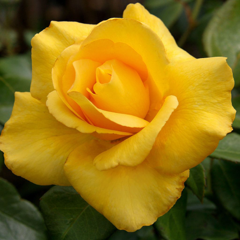

In [46]:
img = Image.open(dest)
img.to_thumb(240, 240)

### Create a Path for all images

In [47]:
flower_types = 'rose', 'lily' ,'marigold' ,'sunflower'
path = Path('flowers1')
path

Path('flowers1')

In [48]:
# In path need folder for each flower which is destination
# Then download images that belong to each destination
if not path.exists():
    path.mkdir()
    for o in flower_types:
        dest = (path/o)
        dest.mkdir(exist_ok = True)
        results = search_images_bing(key, f'{o} flower')
        download_images(dest, urls = results.attrgot('content_url'))

### Test For Images

In [49]:
fns = get_image_files(path)
fns

(#586) [Path('flowers1/lily/00000000.jpg'),Path('flowers1/lily/00000001.jpg'),Path('flowers1/lily/00000002.Jpg'),Path('flowers1/lily/00000003.jpg'),Path('flowers1/lily/00000004.jpg'),Path('flowers1/lily/00000005.jpg'),Path('flowers1/lily/00000006.jpg'),Path('flowers1/lily/00000007.jpg'),Path('flowers1/lily/00000008.jpg'),Path('flowers1/lily/00000009.jpg')...]

In [50]:
failed = verify_images(fns)
failed
#os. unlink and Path.unlink did the same job
#failed.map(os.unlink)

(#0) []

### DataBlocks and DataLoading

In [51]:
# To seperate training testing.Know what is the y what is the x. 
# Get images which are downloaded on path
flowers = DataBlock( 
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.3, seed = 42),
    get_y = parent_label , 
    item_tfms = Resize(148, 148)
)

In [52]:
dls = flowers.dataloaders(path)

### Padding/Resizing/Squishing/Stretching

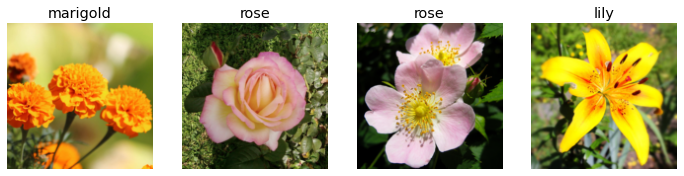

In [53]:
# Original
dls.valid.show_batch(max_n =4, nrows = 1)

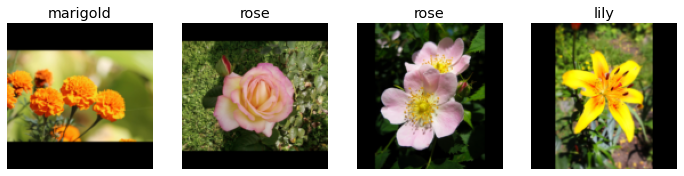

In [54]:
# Padded image 
flowers = flowers.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))
dls = flowers.dataloaders(path)
dls.valid.show_batch(max_n =4, nrows = 1)

## Modelling 

In [55]:
# Random Resize and on each epoch run through a part of image
# Additionally batch augment the data to accomodate subtle differences in variation
flowers = flowers.new(item_tfms = RandomResizedCrop(224, min_scale = 0.3), batch_tfms = aug_transforms(mult = 2))
dls  = flowers.dataloaders(path)

In [56]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.678379,0.746928,0.257143,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.504763,0.250440,0.091429,00:13
1,0.336008,0.109171,0.028571,00:12
2,0.249437,0.091127,0.028571,00:13
3,0.214557,0.088027,0.028571,00:13


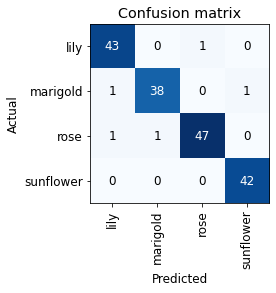

In [57]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

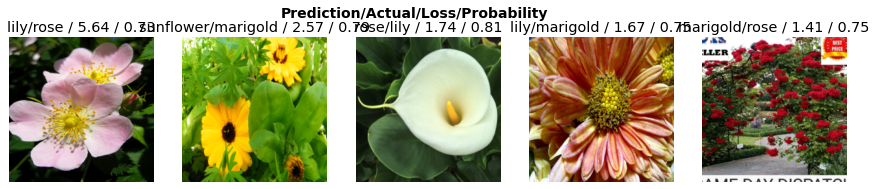

In [58]:
interpret.plot_top_losses(5, nrows=1)

## App Deployment


In [59]:
#Export pkl file to save your architecture parameters and DataLoaders
learn.export()

In [60]:
#check for path
path = Path()
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [61]:
# Load learner 
learn_inf = load_learner(path/'export.pkl')

In [62]:
learn_inf.predict('brose.jpg')

('rose', tensor(2), tensor([1.2686e-03, 4.6050e-05, 9.9800e-01, 6.8566e-04]))

In [63]:
# Upload button to upload the image file
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [64]:
# Output button which displays the output
out = widgets.Output()

In [70]:
#Label widget which can store our predictions
lbl_pred = widgets.Label()
lbl_pred.value = 'Choose your image'

In [71]:
# Classify button
btn_run = widgets.Button(description = 'Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [72]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out.clear_output()
    with out: display(img.to_thumb(150,150))
    pred, pred_idx , probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction : {pred}; Probability : {probs[pred_idx]:.04f}'
    

btn_run.on_click(on_click_classify)

In [73]:
# reset btn_upload
btn_upload = widgets.FileUpload()

In [74]:
widgets.VBox([widgets.Label('Select Your Flower'), btn_upload, btn_run, out, lbl_pred])

In [ ]:
#hide
#pip install voila
#!jupyter serverextension enable voila --sys-prefix